# Biostat M280 Homework 3

Sarah Ji

**Due Friday, May 25 @ 11:59PM**

# Q1 - Big $n$ regression

Those who took my _203B: Introduction to Data Science_ last quarter had a (painful) experience of wrangling an Apache Spark cluster to do linear regression on a dataset with more than 100 million observations. Now we learnt various methods for solving linear regression and should realize that, with right choice of algorithm, it is a problem that can be handled by any moderate computer.

### Q1(1)

Download the flight data from <http://stat-computing.org/dataexpo/2009/the-data.html>. For this exercise, we only need data from years 2003-2008. If you are using Mac or Linux, you can run the following Bash script, which downloads and unzips files for all years.
```bash
# Download flight data by year
for i in {1987..2008}
  do
    echo "$(date) $i Download"
    fnam=$i.csv.bz2
    wget -O ./$fnam http://stat-computing.org/dataexpo/2009/$fnam
    echo "$(date) $i unzip"
    bzip2 -d ./$fnam
  done

# Download airline carrier data
wget -O ./airlines.csv http://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS

# Download airports data
wget -O ./airports.csv https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
```
Find out how many data points in each year.

### Q1(1) Solution:

Below, we use the `countlines()` function in Julia to see how many data points there are in each year. We find that there is a steady increase in the number of data points from years 2003-2007, but a sharp decrease in data points from 2007 to 2008. We suspect this drop in 2008 may be related to the national airport shutdowns following the 9/11 attacks this year. 

In [1]:
# how many data points in 2003
@show countlines("allyears/2003.csv")
# how many data points in 2004
@show countlines("allyears/2004.csv")
# how many data points in 2005
@show countlines("allyears/2005.csv")
# how many data points in 2006
@show countlines("allyears/2006.csv")
# how many data points in 2007
@show countlines("allyears/2007.csv")
# how many data points in 2008
@show countlines("allyears/2008.csv");

countlines("allyears/2003.csv") = 6488541
countlines("allyears/2004.csv") = 7129271
countlines("allyears/2005.csv") = 7140597
countlines("allyears/2006.csv") = 7141923
countlines("allyears/2007.csv") = 7453216
countlines("allyears/2008.csv") = 7009729


### Q1(2) 

We are interested in how the time gain of a flight, defined as `DepDelay - ArrDelay`, depends on the distance traveled (`Distance`), departure delay (`DepDelay`), and carrier (`UniqueCarrier`). 

We want to fit a linear regression `Gain ~ 1 + Distance + DepDelay + UniqueCarrier` using data from 2003-2008. Note `UniqueCarrier` is a factor with 23 levels: "9E", "AA", "AQ", "AS", "B6", "CO", "DH", "DL", "EV", "F9", "FL", "HA", "HP", "MQ", "NW", "OH", "OO", "TZ", "UA", "US", "WN", "XE", and "YV". We use the dummy coding with "9E" as base level.

Will the design matrix (in double precision) fit into the memory of you computer?

### Q1(2) Solution:

First I checked the dimension of the design matrix we need for the regression. Since our model has an intercept, we have 5 columns and counting the number of rows in each year we have 42,363,271 rows. So our design matrix is a 42,363,271 by 5 matrix, and it can fit on the memory of my computer (but I prefer it didn't).

If each number is stored in double precicion, we need 8,629,998,000 bytes or 8.629998 GiB of memory to store this matrix.

In [2]:
#Calculating the number of bytes this data will need
41490375*26*8

8629998000

In [3]:
# import data from csv
using JuliaDB
@time yrtable = loadtable(
    "allyears", 
    datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])
# drop rows with missing values
yrtable = dropna(yrtable)

144.277378 seconds (388.15 M allocations: 17.700 GiB, 3.52% gc time)


Table with 41490375 rows, 4 columns:
DepDelay  ArrDelay  UniqueCarrier  Distance
───────────────────────────────────────────
-4        -1        "UA"           837
-1        -3        "UA"           837
29        23        "UA"           837
-2        -9        "UA"           1835
18        52        "UA"           1835
-4        6         "UA"           1835
-4        -8        "UA"           1835
0         2         "UA"           1835
-4        19        "UA"           1835
3         4         "UA"           413
-4        -23       "UA"           413
-3        -19       "UA"           413
⋮
57        75        "DL"           481
80        99        "DL"           689
-2        15        "DL"           270
-4        6         "DL"           425
-3        16        "DL"           546
-1        2         "DL"           215
3         14        "DL"           533
-1        -2        "DL"           874
-5        0         "DL"           545
11        9         "DL"           533
7        

After we drop missing values, I count again how many bytes this design matrix will use. Even after dropping rows with missing values, we will use 8.62999696 GiB of memory.

Below is the function that maps from variable names to X columns and generates the [X y] matrix. We will use this function to get our design matrix `xy`

In [4]:
# mapping from variable names to X columns
# carrier "9E" is used as base level
const var2col = Dict(
        "Intercept" => 1,
        "Distance" => 2,
        "DepDelay" => 3,
        "AA" => 4,
        "AQ" => 5,
        "AS" => 6,
        "B6" => 7,
        "CO" => 8,
        "DH" => 9,
        "DL" => 10,
        "EV" => 11,
        "F9" => 12,
        "FL" => 13,
        "HA" => 14,
        "HP" => 15,
        "MQ" => 16,
        "NW" => 17,
        "OH" => 18,
        "OO" => 19,
        "TZ" => 20,
        "UA" => 21,
        "US" => 22,
        "WN" => 23,
        "XE" => 24,
        "YV" => 25,
        "Gain" => 26)
# mapping from column to variable names
const col2var = map(reverse, var2col)

# a custom function to generate [X y] from data table
function generate_xy(tbl::NextTable)
    # X matrix
    XY = zeros(length(tbl), 26)
    # intercept term
    @views fill!(XY[:, 1], 1)
    # Distance term
    @views copy!(XY[:, 2], columns(tbl, :Distance))
    # DepDelay term
    @views copy!(XY[:, 3], columns(tbl, :DepDelay))
    # Dummy coding for airline
    @inbounds for i in 1:length(tbl)
        yrtable[i][:UniqueCarrier] == "9E" && continue # base level
        XY[i, var2col[tbl[i][:UniqueCarrier]]] = 1
    end
    # last column is response: gain = depdelay - arrdelay
    XY[:, 26] = select(tbl, 
        (:DepDelay, :ArrDelay) => p -> Float64(p.DepDelay - p.ArrDelay))
    # return
    XY
end

generate_xy (generic function with 1 method)

In [5]:
xy = generate_xy(yrtable)

41490375×26 Array{Float64,2}:
 1.0   837.0  -4.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0   -3.0
 1.0   837.0  -1.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    2.0
 1.0   837.0  29.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    6.0
 1.0  1835.0  -2.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    7.0
 1.0  1835.0  18.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  -34.0
 1.0  1835.0  -4.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  -10.0
 1.0  1835.0  -4.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0    4.0
 1.0  1835.0   0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   -2.0
 1.0  1835.0  -4.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  -23.0
 1.0   413.0   3.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   -1.0
 1.0   413.0  -4.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0   19.0
 1.0   413.0  -3.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   16.0
 1.0   413.0   0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0   12.0
 ⋮      

### Q1(3)

Review the [Summary of Linear Regression](http://hua-zhou.github.io/teaching/biostatm280-2018spring/slides/12-linreg/linreg.html) and devise a strategy to solve the linear regression.

Report the estimated regression coefficients $\widehat \beta$, estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$, and coefficient standard errors.

Hint: It took my laptop less than 3 minutes to import data and fit linear regression.

### Q1(3) Solution:

Notice from above that it takes us 144.322472 seconds to read in the flights datasets from years 2003-2008.

Next, we want to fit the linear regression for the big data problem using Sweep Operators to give us the desired quantities. Sweep Operators are popular in statistical softwares, namely SAS, for performing linear regression and matrix inversion.

To use Sweeep Operators, the matrix that you are sweeping must be symmetric and positive semidefinite. Therefore we will perform Sweep on the symmetric and postive definite ram matrix, $[\mathbf{{X y}^{T}}][\mathbf{{X y}]},$ to get the desired quantities from the function `linreg_sweep_all`.

$$
[\mathbf{{X y}^{T}}][\mathbf{{X y}]} = 
\begin{pmatrix} 
    \mathbf{X}^T \mathbf{X} & \mathbf{X}^T \mathbf{y} \\ 
    \mathbf{y}^T \mathbf{X} & \mathbf{y}^T \mathbf{y} 
\end{pmatrix}
$$ 

calling sweep yields the solution matrix with the desired quantities:

$$
\begin{eqnarray*}
\begin{pmatrix}
- (\mathbf{X}^T \mathbf{X})^{-1} & (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} \\
\mathbf{y}^T \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} & \mathbf{y}^T \mathbf{y} - \mathbf{y}^T \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
\end{pmatrix} = 
\begin{pmatrix}
- \sigma^{-2} \text{Cov}(\beta) & \beta \\
\beta^T & \|\mathbf{y} - \hat y\|_2^2
\end{pmatrix}.
\end{eqnarray*}
$$

We notice that the estimated regression coefficients $\widehat \beta$ can be found in the last column of the solution matrix.

> calling `beta_coeff_est = tableau[1:p, end]` in the function to get this quantity

Additionally, the estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1),$ can be computed from dividing the residual sum of squares in the last cell of the solution matrix by (n - 1)
 
> calling `sigma_hat2 = tableau[end, end] / (n - 1)` in the function to get this quantity

The coefficient standard errors $\text{Cov}(\beta)$ 
> calling `SE_beta_coeff_est = sqrt.(Diagonal( .- sigma_hat2 .* tableau[1:p, 1:p]))` in the function to get this quantity.

In [6]:
using SweepOperator, BenchmarkTools

function linreg_sweep_all(y::Vector, X::Matrix)
    n = size(X, 1)
    p = size(X, 2)
    tableau = [X y]' * [X y]
    sweep!(tableau, 1:p)
    beta_coeff_est = tableau[1:p, end]
    sigma_hat2 = tableau[end, end] / (n - 1) 
    SE_beta_coeff_est = sqrt.(Diagonal( .- sigma_hat2 .* tableau[1:p, 1:p]))
    return beta_coeff_est, sigma_hat2, SE_beta_coeff_est
end

linreg_sweep_all (generic function with 1 method)

In [7]:
beta_coeff_est, sigma_hat2, SE_beta_coeff_est = linreg_sweep_all(xy[:, 26], xy[:, 1:25]);

## $\widehat \beta$

In [8]:
beta_coeff_est

25-element Array{Float64,1}:
  1.14033   
  0.00164935
 -0.0118811 
 -1.8723    
 -0.5789    
 -0.938452  
 -1.42247   
 -2.57627   
  1.16808   
 -2.19625   
  1.03932   
 -2.15207   
 -1.35247   
 -1.87248   
 -0.350758  
 -1.46395   
 -3.62506   
 -0.00722279
 -0.40365   
 -3.5774    
 -1.14816   
 -0.883753  
  2.74855   
 -2.56721   
 -0.202211  

### $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$

In [9]:
sigma_hat2

204.4031074256946

### $\text{Cov}(\beta)$ 

In [10]:
full(SE_beta_coeff_est)

25×25 Array{Float64,2}:
 0.0202318  0.0         0.0         …  0.0        0.0        0.0      
 0.0        4.37958e-6  0.0            0.0        0.0        0.0      
 0.0        0.0         6.88878e-5     0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0         …  0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0         …  0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0        0.0      
 0.0        0.0         0.0            0.0        0.0

### Q1(4)

Go to your resume/cv and claim you have experience performing analytics on data with hundred millions of observations.

### Q1(4) Solution:


I have edited my resume/cv and claimed my experience performing analysis on data with hundred millions of observations.

# Q2 - Google PageRank

We are going to try different numerical methods learnt in class on the [Google PageRank problem](https://en.wikipedia.org/wiki/PageRank).

### Q2(1)

Let $\mathbf{A} \in \{0,1\}^{n \times n}$ be the connectivity matrix of $n$ web pages with entries
$$
\begin{eqnarray*}
	a_{ij}= \begin{cases}
	1 & \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}.
\end{eqnarray*}
$$
$r_i = \sum_j a_{ij}$ is the out-degree of page $i$. That is $r_i$ is the number of links on page $i$. Imagine a random surfer exploring the space of $n$ pages according to the following rules.  

- From a page $i$ with $r_i>0$
    * with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page  
    * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
- From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
    
The process defines a Markov chain on the space of $n$ pages. Write down the transition matrix $\mathbf{P}$ of the Markov chain as a diagonal matrix plus rank-1 matrix.

### Q2(1) Solution:

>Since with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page, if there are ${\sum_j a_{ij}}$ pages the probability of going to each one would be $\frac{1}{{\sum_j a_{ij}}}$.<br> 

>Additionally, we are given: if there are no links on the current page, with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page. If there are n total pages in the world, the probability of going to each one would be $1/n$.<br><br>

>We note that the transition probability of going from page i to page j is:
$$
\begin{eqnarray*}
    p_{ij} = \begin{cases}
    \frac{1}{\sum_j a_{ij}}*p + \frac{1}{n}*(1 - p) & \text{if page $i$ has links on the page, $r_i$ > 0} \\
    \frac{1}{n} & \text{if there are no links on the page $i$, $r_i$ = 0}
    \end{cases}
\end{eqnarray*}
$$<br>
> Replacing $r_i = \sum_j a_{ij}$ we have:
$$
\begin{eqnarray*}
    p_{ij} = \begin{cases}
    \frac{a_{ij}}{r_i}*p + \frac{1}{n}*(1 - p) & \text{if page $i$ has links on the page, $r_i$ > 0} \\
    \frac{1}{n} & \text{if there are no links on the page $i$, $r_i$ = 0}
    \end{cases}
\end{eqnarray*}
$$<br>

>We make note that the structure of transition matrix $P$ is the sum of two terms, a diagonal matrix + a rank-1 matrix, <br> where $\mathbf{\frac{1}{n}} = \frac{1}{n}\mathbf{1^T}$ and $\mathbf{\frac{1-p}{n}} = \frac{1-p}{n}\mathbf{1^T}$ are vectors. Then the resulting Transition Probability Matrix is:

\begin{eqnarray*}
    \mathbf{P} = \begin{cases}
     diag(\frac{p}{r_i})\mathbf{A} + \mathbf{\frac{1-p}{n}}\mathbf{1} & \text{if page $i$ has links on the page, $r_i$ > 0} \\
    diag(0)\mathbf{A} + \mathbf{\frac{1}{n}}\mathbf{1} & \text{if there are no links on the page $i$, $r_i$ = 0}
    \end{cases}
\end{eqnarray*}




### Q2(2)

According to standard Markov chain theory, the (random) position of the surfer converges to the stationary distribution $\mathbf{x} = (x_1,\ldots,x_n)^T$ of the Markov chain. $x_i$ has the natural interpretation of the proportion of times the surfer visits page $i$ in the long run. Therefore $\mathbf{x}$ serves as page ranks: a higher $x_i$ means page $i$ is more visited. It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem. Show that it can also be cast as solving a linear system. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient. We can replace the first equation by the $\sum_{i=1}^n x_i = 1$.

### Q2(2) Solution:

>First we have:
$$\mathbf{P}^T \mathbf{x} = \mathbf{x}$$<br>
>Moving everything to the left side we have:
$$\mathbf{P}^T \mathbf{x} - \mathbf{x} = \mathbf{0}$$<br>
>We can re-write this as:
$$(\mathbf{I} - \mathbf{P}^T) \mathbf{x} = \mathbf{0}$$<br>
>Now, we see that this problem can also be cast as solving a linear system. What we want to find is the solution `x`.
>If we let $\mathbf{C} = (\mathbf{I} - \mathbf{P}^T),$ we know $\mathbf{C}$ is not full rank. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient and we know each column of $\mathbf{C}$ will also sum to 1.<br><br>
>Thus, we can replace the first equation by the $\sum_{i=1}^n x_i = 1$ by replacing the first row of $\mathbf{C}$ with a vector of ones, and create a new vector for the solution, where the first postition is a 1 (indicating we changed the 1st row of matrix $\mathbf{C}$ to ones) and the rest are zeros. <br><br>
>Note that we could choose any of the n rows of matrix $\mathbf{C}$ to be ones, adjusting the corresponding solution vector with a 1 in the position of the row number that was changed.

### Q2(3)

Download the [`ucla.zip`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw3/ucla.zip) package from course webpage. Unzip the package, which contains two files `U.txt` and `A.txt`. `U.txt` lists the 500 URL names. `A.txt` is the $500 \times 500$ connectivity matrix. Read data into Julia. Compute summary statistics:
* number of pages
* number of edges
* number of dangling nodes (pages with no out links)
* which page has max in-degree?
* which page has max out-degree?
* visualize the sparsity pattern of $\mathbf{A}$

### Q2(3) Solution:


In [11]:
# connectivity matrix
A = readcsv("A.txt")
# U = readcsv("U.txt")
U = readlines("U.txt")
# Make diagonals 0 so that probability of going from page i to page i is 0 !
A = A - Diagonal(A)
# Let Julia know A is a sparse matrix since most entries are 0's!
A = sparse(A);
# number of pages
@show n_pages = size(A, 1)
# number of edges (page links)
@show n_edges = countnz(A)
# number of dangling nodes (pages with no out links)
r = sum(A, 2) #number of outlinks per page
@show n_dangling_nodes = n_pages - countnz(r); # total number of pages minus those with out links

n_pages = size(A, 1) = 500
n_edges = countnz(A) = 10853
n_dangling_nodes = n_pages - countnz(r) = 103


There are `n_pages = 500` pages, there are `n_edges = 10,853` edges, and there are `n_dangling_nodes = 103` dangling nodes (pages with no out links) in the connectivity matrix in `A.txt`.

### Max in/out-degree

Next we find which page has the max in-degree and which page has the max out-degree. The in-degree of page `i` is defined to be the number of pages that link to page `i`. Similarly, the out-degree of page `i` is defined to be the number of page links on page `i`. Thus, we are interested in which page has the most traffic coming in, and which page has the most traffic going out by calculing the maximum in/out degree.

We see that the page that has the most traffic coming in is "http://www.ucla.edu", with 171 pages linking in to it. 
We see that the page that has the most traffic going out is "http://giveto.ucla.edu", with 87 pages linking in to it. Makes total sense to me lol

In [12]:
# which page has max in-degree?
n_in_degree_links = sum(A, 1)
@show which_max_nidgl = indmax(n_in_degree_links) #indicates first link has the maximum # of in-degree links
@show max_in_degree_link = U[which_max_nidgl] #print the first link in URL file
@show max_n_in_degree_links = n_in_degree_links[which_max_nidgl]; # number of in-degree links to this page is 171!

which_max_nidgl = indmax(n_in_degree_links) = 1
max_in_degree_link = U[which_max_nidgl] = "http://www.ucla.edu"
max_n_in_degree_links = n_in_degree_links[which_max_nidgl] = 171.0


In [13]:
# which page has max out-degree?
which_max_nodgl = indmax(r)
@show U[which_max_nodgl]
@show r[which_max_nodgl];

U[which_max_nodgl] = "http://giveto.ucla.edu"
r[which_max_nodgl] = 87.0


### Visualizing the Sparsity Pattern of Connectivity Matrix

Below, we use the spy() function in the `Plots.jl` package to visualize the sparsity of the connectivity matrix A in `A.txt`. The shaded cells of the figure below represent where A[i,j] = 1 and there exists a link from page `i` to `j`. The unshaded cells show where A[i, j] = 0 and there does not exists a link from page `i` to `j`.

Looking across the graph, each row `i` without any shading indicate pages where there are no out-links on page `i`.

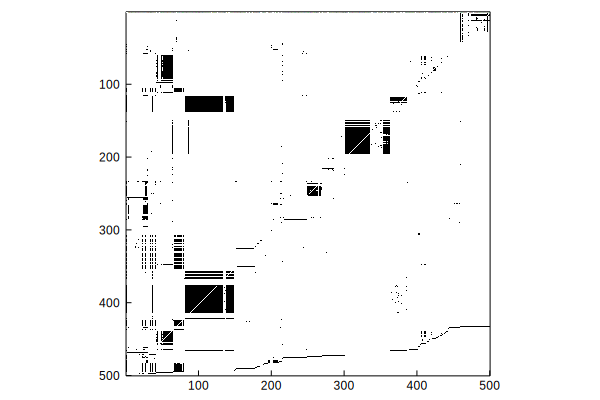

In [14]:
using Plots
spy(A)

### Q2(4)

Set the _teleportation_ parameter at $p = 0.85$. Try the following methods to solve for $\mathbf{x}$ using the `ucla.zip` data.

0. A dense linear system solver such as LU decomposition.  
0. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.   
0. A dense eigen-solver.  
0. A simple iterative eigen-solver such as the power method.  

For iterative methods, you can use the [`IterativeSolvers.jl`](https://github.com/JuliaMath/IterativeSolvers.jl) package. Make sure to utilize the special structure of $\mathbf{P}$ (diagonal + rank 1) to speed up the matrix-vector multiplication.

## Q2(4) Solution:

Below we use four different methods to solve for the stationary distribution, `x`, the long run proportion of time spent on each page. I have written a function for each method of solving this problem, where by default the teleportation parameter is set at p = 0.85. For the iterative solving methods, our functions set by default the maximum number of iterations to 10,000 and we use a tolerance of 1e-7. Since we are given that each page is uniformly likely to be visited, we initialize the stationary distribution at `x_old`, which is a vector of length n of the value $/mathfrac{1}/{n}$.

Using the `ucla.zip` data, we benchmark these methods to compare their efficiencies. 

### Using LU-decomposition

In [15]:
function LU_Decomposition_Linear_Solver(A::AbstractMatrix, telep::Float64 = 0.85)
#first make P
# Matrix P is the sum of a sparse matrix + a rank 1 matrix
n = size(A, 1)
r = sum(A, 2) #sum each row of A to get r_i for each page i
P = zeros(n, n)
term1 = zeros(n)
term2 = repeat([1 / n], outer = [n]) 
for i in 1:n
    if r[i] > 0 
        term1[i] = telep / r[i]
        term2[i] = (1 - telep) / n
    end
end
#first make P^T
P_transpose = (Diagonal(term1) * full(A) .+ term2).'

#then make C = (I- P^t)
C = I - P_transpose
C[1, : ] = ones(n)      
b = zeros(n)
b[1] = 1.0

#use the fact that each column sums to 1 and replace the first row of C with ones
#then solve x = C \ [1, 0, ... , 0] 
    return C \ b
end

LU_Decomposition_Linear_Solver (generic function with 2 methods)

In [16]:
x_LU = LU_Decomposition_Linear_Solver(A)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

## Jacobi Iterative Method

>Note that for our problem we are finding the solution $\mathbf{x}$ to the equation $\mathbf{C}\mathbf{x} = \mathbf{b},$
where $\mathbf{C} = (\mathbf{I} - \mathbf{P^{T}})$

$$x_i^{(t+1)} = \frac{b_i - \sum_{j=1}^{i-1} c_{ij} x_j^{(t)} - \sum_{j=i+1}^n c_{ij} x_j^{(t)}}{c_{ii}}$$

Splitting up Matrix A into the sum of a Lower Triangular, Diagonal and Upper triangular matrix we have: 
$$\mathbf{C} = \mathbf{L} + \mathbf{D} + \mathbf{U}$$<br>
$$x_i^{(t+1)} = -\mathbf{D^{-1}}\mathbf{C}x_i^{(t)} + x_i^{(t)} + \mathbf{D^{-1}}\mathbf{b}$$

>Now substituting back in $\mathbf{C} = (\mathbf{I} - \mathbf{P^{T}})$ we have:
$$x_i^{(t+1)} = -\mathbf{D^{-1}}(\mathbf{I} - \mathbf{P^{T}})x_i^{(t)} + x_i^{(t)} + \mathbf{D^{-1}}\mathbf{b}$$




In [17]:
function Jacobi_Linear_Solver(A::AbstractMatrix, telep::Float64 = 0.85; 
        maxiter::Int = 10000, tolerance::Float64 = 1e-9, 
        x_old::Vector = repeat([1 / size(A, 1)], outer = [size(A, 1)]))
#first make P
# Matrix P is the sum of a sparse matrix + a rank 1 matrix
n = size(A, 1)
r = sum(A, 2) #sum each row of A to get r_i for each page i
P = zeros(n, n)
term1 = zeros(n)
term2 = repeat([1 / n], outer = [n]) 
for i in 1:n
    if r[i] > 0 
        term1[i] = telep / r[i]
        term2[i] = (1 - telep) / n
    end
end
#first make P^T
#P_transpose = (Diagonal(term1) * sparse(A) .+ term2).'

P_term1 = sparse(A') * Diagonal(term1)
P_term2 = ones(n, 1) * term2'
P_t2vector = P_term2[1, :]' #want to make this a vector to speed up the process and reduce memory size
    
x_new = vec(zeros(n))

#then make C = (I - P^t)
C = I - P_term1 - P_term2
b = zeros(n)
    
x_new = zeros(n)

D_inv = inv(Diagonal(C)) 
i = 0
for i in 1:maxiter
x_new = -D_inv * (C * x_old) .+ x_old .+ (D_inv * b)
if vecnorm(x_new - x_old) < tolerance
        break
    end
x_old = x_new       
end
return x_new
end

Jacobi_Linear_Solver (generic function with 2 methods)

In [18]:
x_jacobi = Jacobi_Linear_Solver(A)

500-element Array{Float64,1}:
 0.012771  
 0.00130402
 0.00405434
 0.00398366
 0.00130402
 0.00130402
 0.00130402
 0.00130402
 0.00130402
 0.00130402
 0.00130402
 0.00145093
 0.00141319
 ⋮         
 0.00119598
 0.00149255
 0.00119598
 0.00345969
 0.00211022
 0.00119598
 0.00119598
 0.00849411
 0.00119598
 0.00149114
 0.00119598
 0.00119598

# Dense Eigen-Solver

It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem.
 
We first perform eigen decomposition on $P^{T}$ to get the left eigenvector corresponding to the top eigenvalue 1, and find vector $x_i$, the proportion of times the surfer visits page $i$ in the long run. Therefore `x_dense_eigen_solvers` serves as page ranks.

In [21]:
function Dense_Eigen_Solver(A::AbstractMatrix, telep::Float64 = 0.85)
#first make P
# Matrix P is the sum of a sparse matrix + a rank 1 matrix
n = size(A, 1)
r = sum(A, 2) #sum each row of A to get r_i for each page i
P = zeros(n, n)
term1 = zeros(n)
term2 = repeat([1 / n], outer = [n]) 
for i in 1:n
    if r[i] > 0 
        term1[i] = telep / r[i]
        term2[i] = (1 - telep) / n
    end
end
eigenvals_weights = zeros(n)
#first make P^T
P_transpose = (Diagonal(term1) * full(A) .+ term2).'
# eig-decomposition C
C = eigfact((P_transpose)) # this gets the eigen decomp of P^T which has the eigen values and vectors
    
# we get the real elements of the first column of the eigenvectors of P_transpose
eigenvals_weights = real(C[:vectors][:, 1]) 
    
# use eigen solvers to get the long run frequency of each page
return eigenvals_weights / sum(eigenvals_weights) # find the proportion of time spent in each page over total time
end

Dense_Eigen_Solver (generic function with 2 methods)

In [22]:
x_dense_eigen_solvers = Dense_Eigen_Solver(A)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

In [25]:
function Power_Eigen_Solver69(A::AbstractMatrix, telep::Float64 = 0.85; 
        maxiter::Int = 10000, tolerance::Float64 = 1e-7, 
        x_old::Vector = repeat([1 / size(A, 1)], outer = [size(A, 1)]))
#first make P
# Matrix P is the sum of a sparse matrix + a rank 1 matrix
n = size(A, 1)
r = sum(A, 2) #sum each row of A to get r_i for each page i
P = zeros(n, n)
term1 = zeros(n)
term2 = repeat([1 / n], outer = [n]) 
for i in 1:n
    if r[i] > 0 
        term1[i] = telep / r[i]
        term2[i] = (1 - telep) / n
    end
end

#first make P^T
#P_transpose = (Diagonal(term1) * sparse(A) .+ term2).' # blas2 here so use rank one update
P_term1 = sparse(A') * Diagonal(term1)
P_term2 = ones(n, 1) * term2'
P_t2vector = P_term2[1, :]' #want to make this a vector to speed up the process and reduce memory size
    
x_new = vec(zeros(n))

for i in 1:maxiter
x_new = P_term1*x_old .+ (P_t2vector * x_old) 
        
if vecnorm(x_new - x_old) < tolerance
        break
    end
x_old = x_new       
end
return x_new / sum(x_new)
end

Power_Eigen_Solver69 (generic function with 2 methods)

In [26]:
x_Power69 = Power_Eigen_Solver69(A)

500-element Array{Float64,1}:
 0.0127701 
 0.00130394
 0.00405407
 0.0039834 
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00130394
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345947
 0.00211009
 0.0011959 
 0.0011959 
 0.00849357
 0.0011959 
 0.00149104
 0.0011959 
 0.0011959 

In [27]:
using BenchmarkTools
@benchmark LU_Decomposition_Linear_Solver(A)

BenchmarkTools.Trial: 
  memory estimate:  13.42 MiB
  allocs estimate:  1462
  --------------
  minimum time:     4.615 ms (0.00% GC)
  median time:      7.593 ms (28.86% GC)
  mean time:        7.259 ms (22.65% GC)
  maximum time:     12.044 ms (40.32% GC)
  --------------
  samples:          688
  evals/sample:     1

In [34]:
@benchmark Jacobi_Linear_Solver(A)

BenchmarkTools.Trial: 
  memory estimate:  9.52 MiB
  allocs estimate:  5172
  --------------
  minimum time:     5.086 ms (0.00% GC)
  median time:      7.662 ms (0.00% GC)
  mean time:        7.740 ms (14.73% GC)
  maximum time:     25.605 ms (16.18% GC)
  --------------
  samples:          646
  evals/sample:     1

In [29]:
@benchmark Dense_Eigen_Solver(A)

BenchmarkTools.Trial: 
  memory estimate:  17.40 MiB
  allocs estimate:  1928
  --------------
  minimum time:     95.726 ms (0.00% GC)
  median time:      104.308 ms (2.46% GC)
  mean time:        106.508 ms (2.02% GC)
  maximum time:     138.575 ms (2.11% GC)
  --------------
  samples:          47
  evals/sample:     1

In [30]:
@benchmark Power_Eigen_Solver69(A)

BenchmarkTools.Trial: 
  memory estimate:  4.75 MiB
  allocs estimate:  3232
  --------------
  minimum time:     1.469 ms (0.00% GC)
  median time:      2.014 ms (0.00% GC)
  mean time:        2.544 ms (23.11% GC)
  maximum time:     6.541 ms (57.27% GC)
  --------------
  samples:          1958
  evals/sample:     1

### Q2(5)

List the top 20 ranked URLs you found.

### Q2(5) Solution:

First, we show that the 4 different methods we implement to solve the Google page rank problem give us roughly the same stationary distributions, thus the same page rankings. We compare the values of each of the methods below using the `vecnorm()` function. The values of each method seem to agree, thus we sort the data by the stationary distribution column `x_LU` using the function `sortperm()`. This function is useful because we are able to get the indices of the top 20 (22 for us) pages! 

In [35]:
@show vecnorm(x_LU - x_jacobi)
@show vecnorm(x_LU - x_dense_eigen_solvers)
@show vecnorm(x_LU - x_Power69)
@show vecnorm(x_jacobi - x_Power69)
@show vecnorm(x_dense_eigen_solvers - x_Power69)

vecnorm(x_LU - x_jacobi) = 4.490383853180799e-6
vecnorm(x_LU - x_dense_eigen_solvers) = 2.9112447522968875e-16
vecnorm(x_LU - x_Power69) = 8.866001341035277e-7
vecnorm(x_jacobi - x_Power69) = 4.696010753965762e-6
vecnorm(x_dense_eigen_solvers - x_Power69) = 8.866001339943139e-7


8.866001339943139e-7

We note that there is a 4 way tie between the 19th - 22nd sites, so we print out the top 22 links!

In [32]:
top22 = sortperm(x_LU, rev = true)[1:22]

22-element Array{Int64,1}:
 459
  64
   1
  27
  29
 496
 462
  36
  28
  43
  57
  60
  62
  63
  61
  54
  55
  59
  56
  58
  51
  53

Here are the top 22 links! I think it's funny that the second most popular link is just "http://www"

In [33]:
top22_pages = U[top22]

22-element Array{String,1}:
 "http://schema.org"                                                                     
 "http://www"                                                                            
 "http://www.ucla.edu"                                                                   
 "http://www.directory.ucla.edu"                                                         
 "http://www.universityofcalifornia.edu"                                                 
 "http://schema.org/CreativeWork"                                                        
 "http://schema.org/Text"                                                                
 "http://giveto.ucla.edu"                                                                
 "http://www.registrar.ucla.edu/calendar"                                                
 "http://www.uclalumni.net"                                                              
 "http://www.magazine.ucla.edu/depts/lifesigns/honoring-adolescence"    

### Q2(6)

As of Monday May 11 2018, there are at least 1.83 billion indexed webpages on internet according to <http://www.worldwidewebsize.com/>. Explain whether each of these methods works for the PageRank problem at this scale.

### Q2(6) Solution:


The Google PageRank problem as of May 11, 2008 must rank at least 1.83 billion webpages on the internet.

To solve this problem, want to find the top left eigenvector of the transition matrix  P . Direct methods such as (unsymmetric) QR or SVD takes forever. Iterative methods such as power method is feasible. However power method may take a large number of iterations to converge.

Note that the Indexed Web currently contains at least 3.07 billion pages as of Thursday, 24 May, 2018. The Google page rank problem is growing rapidly in scale, as we speak! Thus finding feasible methods to analyze this problem becomes increasingly important as the size of the data grows.

### Direct methods (flops fixed a priori) vs iterative methods:

0. Direct method (GE/LU, Cholesky, QR, SVD): good for dense, small to moderate sized  A matrices
0. Iterative methods (Jacobi, Gauss-Seidal, SOR, conjugate-gradient, GMRES): good for large, sparse, structured linear system, parallel computing, warm start



0. A dense linear system solver - LU decomposition  (doesn't work)
> A dense linear system solver such as LU decomposition would not work for the Google PageRank problem at this scale. Since direct methods The number of flops required are fixed a priori, and would take millions of years to compute.

0. A simple iterative linear system solver - Jacobi  (works!)
> A simple iterative linear system solver such as the Jacobi method would work for the Google PageRank problem at this scale. In general, iterative methods are good for large, sparse, structured linear system, parallel computing, and can benefit from a "warm start". A warm start is a good guess to initialize the algorithm. Utilizing the sparsity of the connectivity matrix $\mathbf{A},$ we can optimize our code efficiency. 

0. A dense eigen solver - (doesn't work)
> A dense eigen solver would not work for the Google PageRank problem at this scale. Since direct methods fix the number of flops required a priori, it would take millions of years to compute.

0. A simple iterative eigen-solver - the power method  (works!)
> A simple iterative eigen-solver such as the power method would work for the Google PageRank problem at this scale. In general, iterative methods are good for large, sparse, structured linear system, parallel computing, and can benefit from a "warm start". A warm start is a good guess to initialize the algorithm. Utilizing the sparsity of the connectivity matrix $\mathbf{A},$ we can optimize our code efficiency. 